In [89]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.cluster import KMeans 
import itertools
import pulp
import cvxpy as cp
import pandas as pd 
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
import numpy as np
import json
import urllib.request

In [90]:
model = models.resnet18(pretrained=True)
model.eval()

/home/infres/xnguyen-24/miniconda3/envs/xai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/xnguyen-24/miniconda3/envs/xai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [91]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ví dụ ảnh đầu vào
img_path = "datasets/images/cat.jpg" 
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)  # (1, 3, 224, 224)

In [92]:
with torch.no_grad():
    output = model(input_tensor)

# Tải danh sách nhãn ImageNet
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

# In top-5 nhãn
probs = torch.nn.functional.softmax(output[0], dim=0)
top5 = torch.topk(probs, 5)
for idx in top5.indices:
    print(imagenet_classes[idx], probs[idx].item())

tabby 0.3777613639831543
tiger cat 0.23486894369125366
lynx 0.05962352827191353
Egyptian cat 0.05724630877375603
red fox 0.049240224063396454


In [93]:
rgb_img = np.array(img.resize((224, 224))) / 255.0

In [94]:
target_layers = [model.layer4[-1]]

In [95]:
cam = GradCAM(model=model, target_layers=target_layers)

In [96]:
with torch.no_grad():
    outputs = model(input_tensor)
top1 = outputs.argmax().item()
print(f"Predicted class: top1 = {top1}")

probs_2 = torch.nn.functional.softmax(output[0], dim=0)
top2 = torch.topk(probs_2, 1)
for idx in top2.indices:
    print(imagenet_classes[idx], probs_2[idx].item())
    print(idx)

Predicted class: top1 = 281
tabby 0.3777613639831543
tensor(281)


In [97]:
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(top1)])
grayscale_cam = grayscale_cam[0]  

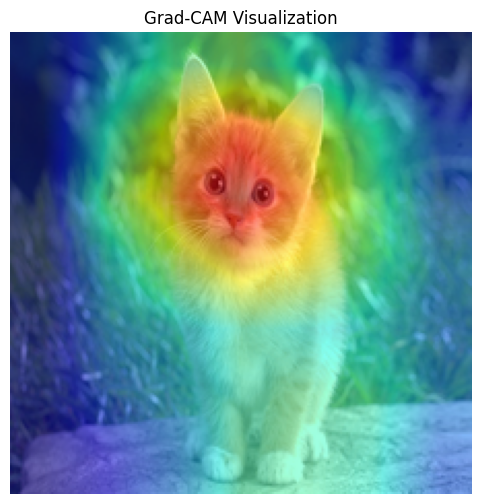

In [98]:
# Áp heatmap lên ảnh gốc
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb = True)

# Hiển thị ảnh với heatmap Grad-CAM
plt.figure(figsize=(6, 6))
plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


# Function defines 

Sử dụng K-means để phân cụm các feature maps có độ tương đồng lớn 

In [99]:
# co the su dung global average pooling cho moi feature map 
# hien tai dang chuyen thanh vector 1 chieu 

def group_feature_maps(
    list_feature_maps: torch.Tensor | np.ndarray,
    number_of_clusters: int,
    ) -> list[tuple[int, ...]]:
    
    """
    Args:
        list_feature_maps (torch.Tensor or np.ndarray):
        Tensor or array of feature maps with shape (C, H, W) or (C, H*W).
        number_of_clusters (int): number of clusters to form.

    Returns:
        list[tuple[int, ...]]: Each tuple contains the channel indices in one cluster.
    """
    if not isinstance(number_of_clusters, int):
        raise ValueError("number of clusters must be an integer")
    
    # Convert to numpy array if torch.Tensor
    if isinstance(list_feature_maps, torch.Tensor):
        data = list_feature_maps.detach().cpu().numpy()
    else:
        data = list_feature_maps
    
    # Determine number of channels
    C = data.shape[0]
    if number_of_clusters < 1 or number_of_clusters > C:
        raise ValueError(
            f"number_of_clusters must be between 1 and {C}, got {number_of_clusters}"
        )
        
    
    # Flatten spatial dimensions (H, W) into feature vector
    flattened = data.reshape(C, -1)  # shape: (C, H*W)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
    labels = kmeans.fit_predict(flattened)
    
    # Build clusters of indices
    groups: list[tuple[int, ...]] = []
    for cluster_idx in range(number_of_clusters):
        idxs = tuple(int(i) for i in np.where(labels == cluster_idx)[0])
        groups.append(idxs)

    return groups

In [100]:
def group_last_conv_feature_maps(
    model: nn.Module,
    input: torch.Tensor,
    target_module: nn.Module,
    number_of_clusters: int,
    ) -> list:
    
    """ 
    Group the feature maps of the last convolutional layer of a model using KMeans clustering.
    Args:
        model (nn.Module): model to run the forward pass on
        input (torch.Tensor): input to the model 
        target_module (nn.Module): module to get the feature maps from
        number_of_clusters (int): number of clusters to form 
    Returns: Nhóm các chỉ số của các feature maps ví dụ [(0, 1), (2, 3), (4, 5)]; (0, 1) là cụm 1
    """
    feature_maps = None 
    
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output.detach().cpu()
        return output
    # Register the forward hook on the target_module
    hook = target_module.register_forward_hook(hook_fn)
    _ = model(input)
    hook.remove()
    
    if feature_maps is None:
        raise ValueError("Cannot extract feature maps from target_module.")
    
    n_feature_maps = feature_maps.shape[1]  # C
    groups = group_feature_maps(feature_maps[0], number_of_clusters) #(1, C, H, W) => (C, H, W)
    
    return n_feature_maps, groups

In [101]:
target_module = model.layer4[-1]

In [102]:
n_feature_maps, groups = group_last_conv_feature_maps(model, input_tensor, target_module, number_of_clusters=10)

In [103]:
n_feature_maps

512

Che feature maps xác định bằng 0 và tính toán output của model

In [ ]:
def do_masked_forward( model: nn.Module, 
                    input: torch.Tensor,
                    target_module: nn.Module,
                    mask_indices: list | torch.Tensor,
                    mask_value: float = 0.0,
                    ) -> torch.Tensor:
    
    """
    Run a forward pass through a model while masking specific channels in the output for a target module. 
    This is useful for analyzing the contribution of specific channels to the model's output.
    Args:
        model (nn.Module): model to run the forward pass on
        input (torch.Tensor): input to the model 
        mask_indices (list | torch.Tensor): indices of channels to mask
        mask_value (float, optional): Defaults to 0.0.
    """
    def hook_fn(module, input, output):
        # Mask the specified channels in the output
        device = output.device  # Lấy device của output (CPU hoặc GPU)
    
        if isinstance(mask_indices, list):
            idx = torch.tensor(mask_indices, dtype=torch.long, device=device)
        else:
            idx = mask_indices.to(dtype=torch.long, device=device)

        if output.dim() >= 2:  # (N, C, H, W) hoặc (N, C)
            # print(f"Idx: {idx}")
            output[:, idx, ...] = mask_value
    
    # Register the forward hook on the target_module
    hook = target_module.register_forward_hook(hook_fn)
    
    # Run the forward pass through the entire model
    out = model(input)
    
    # Remove the hook
    hook.remove()
    return out
    

In [105]:
# mask_indices = [1, 20, 30]
# mask_indices = [0,1,2,5] 

In [106]:
# output = do_masked_forward(model, x, target_module, mask_indices, mask_value=0.0)
# print("Output shape:", output.shape)

Tính contributions của từng nhóm 

In [113]:
def value_func(coalition: list[tuple[int, ...]],
                model: nn.Module,
                input: torch.Tensor,
                target_module: nn.Module,
                n_channels: int,
                target_class: int,
                mask_value: float = 0.0,
                ) -> float: 
    """
    Tính đóng góp của coalition dựa trên đầu ra của model. Các kênh không thuộc coalition sẽ bị mask bằng giá trị 0.0.
    Args:
        coalition (list):  Danh sách các nhãn nhóm (group labels) được giữ bật (unmasked). Ví dụ coalition = [(0, 1), (2, 3)]
        model (nn.Module): CNN model 
        input (torch.Tensor): ảnh đầu vào (B, C, H, W)
        target_module (nn.Module): lớp conv mà feature maps được trích xuất
        n_channels: số lượng kênh trong feature map
        target_class (int): class mục tiêu để tính toán đóng góp 
    """
    # 1) flatten toàn bộ channel trong coalition
    unmask = set()
    for group in coalition:
        unmask.update(group)
        
    # 2) danh sách các channel phải mask = những c ∉ unmask
    mask_indices = [c for c in range(n_channels) if c not in unmask]
    # print(f"Masking channels: {mask_indices}")
   
    # 3) chạy forward với hook
    with torch.no_grad():
        output = do_masked_forward(model, input, target_module, mask_indices, mask_value)
        probs = torch.nn.functional.softmax(output[0], dim=0)
    
    # top5 = torch.topk(probs, 5)
    # print("Top-5 class indices and probabilities:")
    # for idx, p in zip(top5.indices.tolist(), top5.values.tolist()):
    #     print(f"Class {idx}: {p:.4f}")
        
    # 4) trả về logit/score cho target_class
    target_output = float(probs[target_class].item())
    
    return target_output

In [114]:
target_output = value_func(groups, model, input_tensor, target_module, n_channels=512, target_class=281, mask_value=0.0)
print("Coalition:", groups)
print("Target output:", target_output)

Idx: tensor([], dtype=torch.int64)
Coalition: [(17, 65, 121, 157, 231, 249, 280, 297, 311, 312, 380, 488, 492), (16, 22, 34, 36, 47, 52, 64, 66, 73, 75, 78, 79, 80, 105, 111, 112, 113, 117, 134, 151, 158, 175, 183, 195, 198, 215, 218, 226, 235, 238, 251, 272, 287, 291, 296, 300, 302, 306, 308, 325, 328, 334, 335, 341, 342, 363, 370, 377, 379, 381, 382, 394, 397, 406, 407, 408, 412, 417, 427, 439, 440, 446, 448, 460, 468, 469, 470, 476, 480, 484, 499, 500, 507), (2, 48, 81, 99, 140, 191, 194, 206, 265, 268, 290, 309, 314, 345, 364, 373, 404, 449, 451, 491), (5, 14, 38, 62, 63, 96, 125, 126, 128, 146, 147, 155, 176, 177, 200, 202, 205, 207, 222, 224, 227, 240, 245, 247, 281, 293, 305, 319, 320, 324, 338, 348, 350, 353, 357, 376, 384, 387, 392, 432, 467, 496, 503, 504, 508, 509), (11, 70, 122, 130, 167, 179, 180, 188, 192, 225, 229, 233, 237, 255, 267, 298, 360, 368, 461, 493), (13, 35, 42, 43, 51, 61, 152, 156, 163, 169, 189, 246, 269, 282, 299, 301, 307, 310, 317, 356, 367, 369, 390, 41

In [ ]:
# def compute_nucleolus(num_players, characteristic_func):
    
#     players = list(range(num_players))
    
#     # Set up the linear programming problem
#     prob = pulp.LpProblem("Nucleolus", pulp.LpMinimize)
    
#     # Decision variables: one allocation x_i per player and epsilon
#     x = {i: pulp.LpVariable(f"x_{i}", lowBound=None, cat='Continuous') for i in players}
#     epsilon = pulp.LpVariable("epsilon", lowBound=None, cat='Continuous')
    
    
#     # Objective: minimize epsilon (the worst excess)
#     prob += epsilon, "Minimize_epsilon"
    
#     # Efficiency constraint: total allocation equals the value of the grand coalition
#     grand_coalition = tuple(players)
#     prob += pulp.lpSum([x[i] for i in players]) == characteristic_func(grand_coalition), "Efficiency"
    
#     # For every proper coalition (nonempty and not the grand coalition),
#     # ensure that the allocated sum is at least v(S) - epsilon.
#     for r in range(1, num_players):
#         for S in itertools.combinations(players, r):
#             S = tuple(sorted(S))
#             prob += pulp.lpSum([x[i] for i in S]) >= characteristic_func(S) - epsilon, f"Coalition_{S}"
    
#     # Solve the LP
#     prob.solve()
    
    # allocation = [pulp.value(x[i]) for i in players]
    # eps_val = pulp.value(epsilon)
    
    # return allocation, eps_val

In [ ]:
def compute_group_contributions(
    model: nn.Module,
    input: torch.Tensor,
    target_module: nn.Module,
    number_of_clusters: int,
    target_class: int = 463,
    mask_value: float = 0.0,
):
    """
    Solve for the nucleolus allocation x ∈ R^G over G groups of feature‐maps.
    
    Args: 
        model: DNN model
        input: Ảnh đầu vào 
        target_module: Lớp tích chập extract feature maps
        number_of_clusters: số lượng nhóm kênh 
        target_class: class mục tiêu để tính toán đóng góp
        mask_value: giá trị để mask các kênh không thuộc coalition, default = 0 
    Returns:
      x_opt: ndarray of shape (G,)
      epsilon_opt: the minimized maximum excess

    """
    # 1) group feature maps
    n_channels , groups = group_last_conv_feature_maps(model, input, target_module, number_of_clusters) #e.g: groups = [(0, 1), (2, 3), (4, 5)]
    print("Groups:", groups)
    # Số lượng kênh 
    G = len(groups)

    # 2) Tính v(S) cho mỗi coalition S (tập tuple group indices) ⊂ {0,…,G−1}
    coalitions = []
    for r in range(1, G+1):
        for combo in itertools.combinations(range(G), r):
            coalition = [groups[i] for i in combo]
            coalitions.append((combo, coalition))
    # Bao gồm full coalition
    full_idx = tuple(range(G))
    

    # Tính v cho từng coalition
    v: dict[tuple[int, ...], float] = {} # {"(0,1)": 0.5, "(2,3)": 0.3}
    v[full_idx] = value_func(groups, model, input, target_module, n_channels, target_class , mask_value)
    print("v(full_idx):", v[full_idx])
    for idxs, coalition in coalitions:
        if idxs != full_idx:
            v[idxs] = value_func(coalition, model, input, target_module, n_channels, target_class, mask_value)
    
    records = [
        {"coalition": str(coal), "value": val}
        for coal, val in v.items()
    ]
    df = pd.DataFrame(records)
    csv_path = "/home/infres/xnguyen-24/XAI/results/coalition_values.csv"
    df.to_csv(csv_path, index=False)
    print(f"Coalition values saved to {csv_path}")
            

   # 3) Khởi tạo biến CVXPY
    x = cp.Variable(G)
    eps = cp.Variable()
    cons = [cp.sum(x) == v[full_idx], x >= 0, eps >= 0]
    for S, val in v.items():
        if S != full_idx:
            cons.append(cp.sum(x[list(S)]) >= val - eps)

    prob = cp.Problem(cp.Minimize(eps), cons)
    prob.solve(solver=cp.SCS)
    if prob.status not in (cp.OPTIMAL, "optimal"):
        raise RuntimeError(f"LP did not solve: {prob.status}")
    
    return x.value, eps.value


In [ ]:
x, eps = compute_group_contributions(
    model,
    input=x,
    target_module=target_module,
    number_of_clusters=10,
    target_class=0,
    mask_value=0.0
)
print("x:", x)
print("epsilon:", eps)

Groups: [(17, 65, 121, 157, 231, 249, 280, 297, 311, 312, 380, 488, 492), (16, 22, 34, 36, 47, 52, 64, 66, 73, 75, 78, 79, 80, 105, 111, 112, 113, 117, 134, 151, 158, 175, 183, 195, 198, 215, 218, 226, 235, 238, 251, 272, 287, 291, 296, 300, 302, 306, 308, 325, 328, 334, 335, 341, 342, 363, 370, 377, 379, 381, 382, 394, 397, 406, 407, 408, 412, 417, 427, 439, 440, 446, 448, 460, 468, 469, 470, 476, 480, 484, 499, 500, 507), (2, 48, 81, 99, 140, 191, 194, 206, 265, 268, 290, 309, 314, 345, 364, 373, 404, 449, 451, 491), (5, 14, 38, 62, 63, 96, 125, 126, 128, 146, 147, 155, 176, 177, 200, 202, 205, 207, 222, 224, 227, 240, 245, 247, 281, 293, 305, 319, 320, 324, 338, 348, 350, 353, 357, 376, 384, 387, 392, 432, 467, 496, 503, 504, 508, 509), (11, 70, 122, 130, 167, 179, 180, 188, 192, 225, 229, 233, 237, 255, 267, 298, 360, 368, 461, 493), (13, 35, 42, 43, 51, 61, 152, 156, 163, 169, 189, 246, 269, 282, 299, 301, 307, 310, 317, 356, 367, 369, 390, 415, 437, 501, 502), (10, 58, 106, 107, 